### This is to compare 3 cases in determining thermodynamic factors, transference number, electro-osmotic coefficient 

In [1]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl; 
from openpyxl import load_workbook
import sympy as sy; from sympy import symbols,diff,Matrix,Eq, solve
fs=11; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
import os

In [2]:
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Input/")
Target  = 'Plot_Para/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Path_Fig_save = BasicPath + Target

In [3]:
# define constant:   - This is from Taeho's measurement
V_bar_zero = 1.0347e-04 # m3/mol
V_bar_o= 6.5312e-05 # m3/mol
V_bar_e = 5.0943e-05 # m3/mol
m_bar_e  = 151.905*1e-3 #   kg/mol
# Xi_tilde = 3.2

In [4]:
# range: 0<y_o<0.75; 0.002<y_e<0.15
# actually during model, 0.2<y_o< 0.65

In [5]:
def LJP_1_Specie_y_np(y_e,T):   # ALL IN ISO Units, range limit: 0< y_e <= 0.15 
    # Eq. (13):
    R = 8.31446261815324
    F = 96485.3321
    aln = 1.491; a0 = 3.007; a1 = -8.168; a2 = 199.6
    delta_U = R*T/F*(
        aln * np.log(y_e) + a0 + a1*y_e  + a2 * y_e**2
    )
    return delta_U

def LJP_2_Species_y_np(y_e,y_EC):
    T = 298.15;
    # y0 = c0/cT;   y_e = ce/cT;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*y_e**0.5 + 185.4*y_e - 402.4*y_e**1.5 
        + 236.9*y_e**2 + 253.7*y_e**2.5 - 408.1*y_e**3 
        + 2509*y_e**3.5 - 2886*y_e**4.5 + 1.174*np.log(y_e) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*np.log(y_e) + b0 + b1*y_e + b2*y_e**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  y_EC  * (
        (1-y_EC-2*y_e) * (
        p + q*y_EC + r*(1-y_EC-2*y_e)
        )
    )
    # Eq. (17):
    delta_U = (
        ( 1 - y_EC/(1-2*y_e)  ) * delta_U_1to0 
        + y_EC/(1-2*y_e) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V


/tmp/ipykernel_5243/3269929872.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(Cases))


Text(0.5, 0, '$y_\\mathrm{e}$')

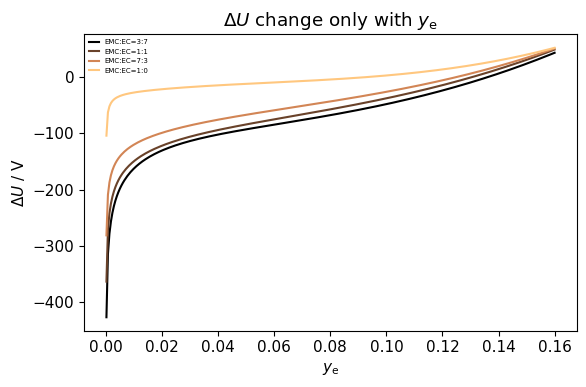

In [6]:
# plot delta_U as one species
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Y_e = np.linspace(1E-4,0.16,300).tolist(); T=298.75
delta_U_1Species_1 = []; delta_U_1Species_2 = []; 
for y_e in Y_e:
    delta_U_1Species_2.append(LJP_1_Specie_y_np(y_e,T))
fig, ax = plt.subplots(figsize=(6, 4), tight_layout='constrained')
Cases = ["EMC:EC=3:7", "EMC:EC=1:1", "EMC:EC=7:3", "EMC:EC=1:0"]
cop2 = mpl.cm.get_cmap("copper", len(Cases))
Ratios = [7/10, 1/2, 3/10, 0]
for i in range(len(Cases)):
    x_plot = Y_e
    y_plot = []
    for y_e in Y_e:
        y_EC = (1-2*y_e) * Ratios[i]
        y_plot.append( LJP_2_Species_y_np(y_e, y_EC)*1e3  ) 
    ax.plot(x_plot, y_plot,"-",color=cop2(i),label=Cases[i])

#ax.plot(Y_e,np.array(delta_U_1Species_2)*1e3,'--',label="EMC:EC=1:1-single")
ax.legend(prop={'family':'DejaVu Sans','size':fs-6},
    frameon=False,markerscale=1,borderpad=0.2,
    handlelength=1.5,columnspacing=1)
ax.set_ylabel("$\Delta U$ / V")
ax.set_title("$\Delta U$ change only with $y_\mathrm{e}$")
ax.set_xlabel("$y_\mathrm{e}$")


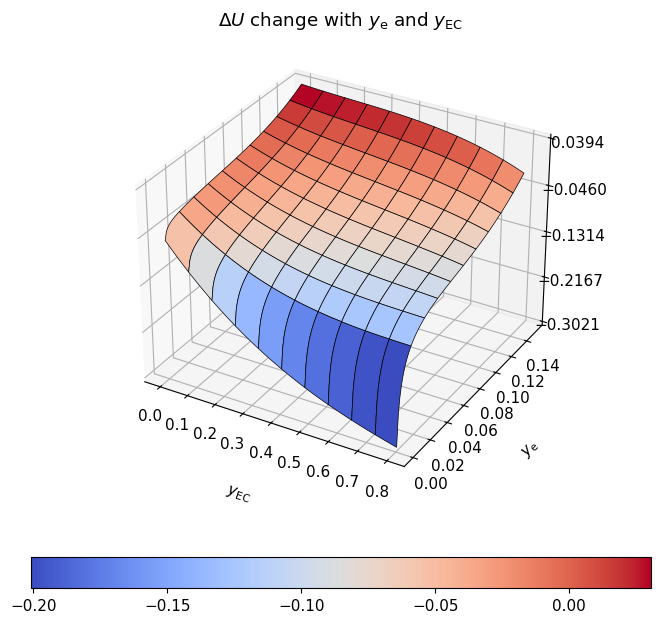

In [7]:
# Plot LJP 2D
Y_e = np.linspace(1E-3,0.15,100).tolist(); 
Y_o = np.linspace(1E-3,0.80,100).tolist(); 
Y_o, Y_e = np.meshgrid(Y_o, Y_e)
delta_U2 = LJP_2_Species_y_np(Y_e,Y_o)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(20, 8))
# Plot the surface.
surf = ax.plot_surface(
    Y_o, Y_e, delta_U2,
    rstride=10, cstride=10, cmap=cm.coolwarm, # Adjusting rstride and cstride for less density
    linewidth=0.5, edgecolor='k', antialiased=True) 

ax.zaxis.set_major_locator(LinearLocator(5))

ax.set_zlabel("$\Delta U$ / V")
ax.set_title("$\Delta U$ change with $y_\mathrm{e}$ and $y_\mathrm{EC}$")
ax.set_ylabel("$y_\mathrm{e}$",)
ax.set_xlabel("$y_\mathrm{EC}$")

ax.xaxis.labelpad = 15  # Adjust the x-axis label position
ax.yaxis.labelpad = 15  # Adjust the y-axis label position
ax.zaxis.labelpad = 40  # Adjust the z-axis label position

# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:1.f}')

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, orientation='horizontal', pad=0.1, shrink=0.4)


In [8]:
# Get junction coefficients
def Fun_u_EC(y_e, y_EC): # Eq. (12) in Jung 2023 paper
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321
    # x,y=symbols("x y",real=True)
    # d_deltaU_dyEC = diff(LJP_2_Species_y_sy(x,y),y) # x: y_e; y: y_EC
    d_deltaU_dyEC = 0.174966463856865*y_EC*(-2*y_e - y_EC + 1) - 0.0256925791272929*y_EC*(89.6*y_e + 6.81*y_EC - 12.6) + 0.0256925791272929*(-2*y_e - y_EC + 1)*(89.6*y_e + 6.81*y_EC - 12.6) + (12.2784835649333*y_e**2 - 2.26403007269705*y_e + 0.0776943592809339*np.log(y_e) + 0.211527003955003)/(1 - 2*y_e) - (-1.10889171513396*y_e**0.5 - 10.4851415418483*y_e**3 + 6.0865719952557*y_e**2 + 4.76340417020011*y_e - 10.3386938408227*y_e**1.5 + 6.51820732459422*y_e**2.5 + 64.462681030378*y_e**3.5 - 74.1487833613674*y_e**4.5 + 0.0301630878954419*np.log(y_e) + 0.184138714605309)/(1 - 2*y_e)

    u_EC = F/(R*T) * d_deltaU_dyEC   # .subs({x:y_e,  y:y_EC })
    return u_EC

def Fun_y_e_u_e(y_e, y_EC): # Eq. (12) in Jung 2023 paper
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321
    # x,y=symbols("x y",real=True)
    # d_deltaU_dye = diff(LJP_2_Species_y_sy(x,y),x) # x: y_e; y: y_EC
    d_deltaU_dye = 2.30205508980545*y_EC*(-2*y_e - y_EC + 1) - 0.0513851582545859*y_EC*(89.6*y_e + 6.81*y_EC - 12.6) + y_EC*(24.5569671298666*y_e - 2.26403007269705 + 0.0776943592809339/y_e)/(1 - 2*y_e) + 2*y_EC*(12.2784835649333*y_e**2 - 2.26403007269705*y_e + 0.0776943592809339*np.log(y_e) + 0.211527003955003)/(1 - 2*y_e)**2 - 2*y_EC*(-1.10889171513396*y_e**0.5 - 10.4851415418483*y_e**3 + 6.0865719952557*y_e**2 + 4.76340417020011*y_e - 10.3386938408227*y_e**1.5 + 6.51820732459422*y_e**2.5 + 64.462681030378*y_e**3.5 - 74.1487833613674*y_e**4.5 + 0.0301630878954419*np.log(y_e) + 0.184138714605309)/(1 - 2*y_e)**2 + (-y_EC/(1 - 2*y_e) + 1)*(-0.554445857566982/y_e**0.5 - 15.508040761234*y_e**0.5 - 31.4554246255448*y_e**2 + 12.1731439905114*y_e + 16.2955183114856*y_e**1.5 + 225.619383606323*y_e**2.5 - 333.669525126154*y_e**3.5 + 4.76340417020011 + 0.0301630878954419/y_e)

    u_e = F/(R*T) * d_deltaU_dye    # .subs({x:y_e,  y:y_EC })
    return u_e * y_e

/tmp/ipykernel_5243/985863485.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap  = mpl.cm.get_cmap("cool", len(y_e_list))
/tmp/ipykernel_5243/985863485.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(Cases))


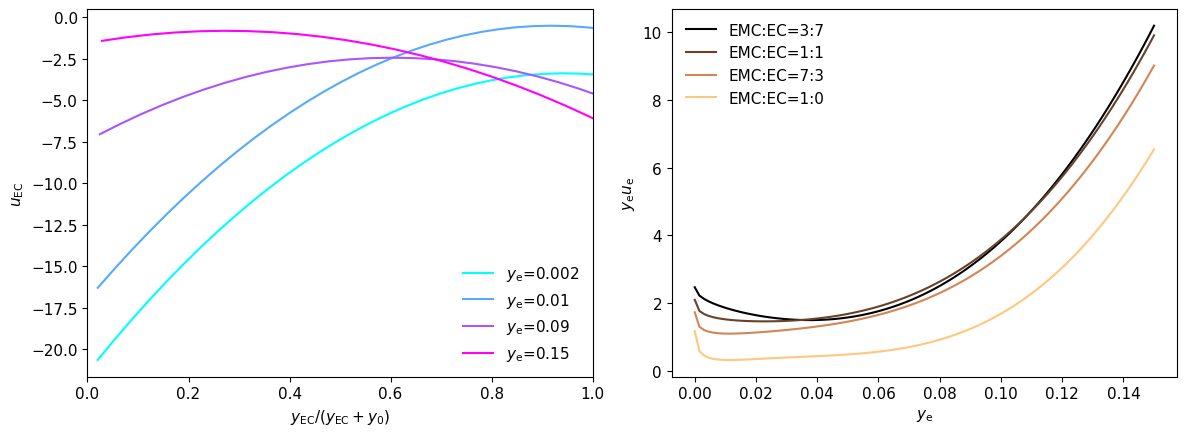

In [9]:
# Plot junction coefficients - reproduce Fig. 5 and 6 in Jung 2023 paper
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
# plot the first one:
y_e_list = [0.002, 0.01, 0.09, 0.15]
T=298.75
y_EC_array = np.linspace(0.02,1.00,30)
cmap  = mpl.cm.get_cmap("cool", len(y_e_list)) 

for i in range(len(y_e_list)):
    x_plot = y_EC_array / (1-2*y_e_list[i])
    y_plot = []
    for y_EC in y_EC_array:
        y_plot.append(Fun_u_EC(y_e_list[i], y_EC))
    axs[0].plot(x_plot, y_plot,"-",color=cmap(i),label=r"$y_\mathrm{e}$=" + f"{y_e_list[i]}")
axs[0].set_xlim(0,1)
axs[0].set_xlabel("$y_\mathrm{EC} / (y_\mathrm{EC}+y_\mathrm{0})$")
axs[0].set_ylabel("$u_\mathrm{EC}$")
axs[0].legend(frameon=False)
# Plot the second one:
y_e_array = np.linspace(1e-10,0.15,100)
# EMC:EC=3:7, 1:1, 7:3, 1:0
Cases = ["EMC:EC=3:7", "EMC:EC=1:1", "EMC:EC=7:3", "EMC:EC=1:0"]
cop2 = mpl.cm.get_cmap("copper", len(Cases))
Ratios = [7/10, 1/2, 3/10, 0]
for i in range(len(Cases)):
    x_plot = y_e_array
    y_plot = []
    for y_e in y_e_array:
        y_EC = (1-2*y_e) * Ratios[i]
        y_plot.append( Fun_y_e_u_e(y_e, y_EC)  ) 
    axs[1].plot(x_plot, y_plot,"-",color=cop2(i),label=Cases[i])
axs[1].set_ylabel("$y_\mathrm{e}u_\mathrm{e}$")
axs[1].set_xlabel("$y_\mathrm{e}$")
axs[1].legend(frameon=False)

In [10]:
# Implement Eq. (23) in Jung 2023 paper:
D_oo = 5e-10; D_ee = 3e-10
# Define the symbols used in the matrix
D_oe, D_eo, cur_D_o, cur_D_e, cur_D_x, X_oo, X_oe, X_eo, X_ee, y_e, y_o, u_o, u_e_y_e, t_0plus,Xi_tilde = symbols(
    'D_oe D_eo cur_D_o cur_D_e cur_D_x X_oo X_oe X_eo X_ee y_e y_o u_o u_e_y_e t_0plus Xi_tilde')
y_zero = 1-2*y_e-y_o
C_11 = 1 + 2*y_e / y_zero + (V_bar_o*y_o) / (V_bar_zero*y_zero) 
C_12 = (V_bar_e - 2*V_bar_zero)*y_o / (V_bar_zero*y_zero) 
C_21 = (V_bar_o - V_bar_zero)*y_e / (V_bar_zero*y_zero) 
C_22 = 1 + y_o/y_zero + (V_bar_e*y_e) / (V_bar_zero*y_zero) 
# Define matrices
D = Matrix([[D_oo, D_oe], [D_eo, D_ee]]) 
cur_D = Matrix([[cur_D_o, 2*cur_D_x*y_o], [cur_D_x*y_e, 2*cur_D_e]])
X = Matrix([[1 + X_oo, X_oe], [X_eo, 2 + X_ee]])
C = Matrix([[C_11, C_12], [C_21, C_22]])
Eq_23 =Eq(cur_D*X*C ,D)
Sol_D = solve(Eq_23, (D_oe, cur_D_o, cur_D_e, cur_D_x)) # solve equations and get expression
# Sol_Xij[X_eo].subs({X_ee:1,t_0plus:0.4,y_e:0.2, y_o:0.4, u_e_y_e:1,u_o:1}) # substitube values
# Implement Eq. (4) and (10) in Jung 2023 paper, to get X_oo,X_eo,X_oe
# Eq. (4)
Eq_4 = Eq( y_o*(1-y_o)*X_eo-y_e*(1-2*y_e)*X_oe , y_e*y_o*(X_ee-2*X_oo))
# Eq. (10)
Eq_10_1 = Eq(u_o     ,  -(Xi_tilde+1)*X_oo + (1-t_0plus)*X_eo/y_e )
Eq_10_2 = Eq(u_e_y_e ,  (2+X_ee)*(1-t_0plus) - Xi_tilde*X_oe*y_e )

# Here we have to assume Eq. (4) has been satisfied, even though it is NOT
Sol_Xij_Case_2 = solve((Eq_10_1, Eq_10_2), (t_0plus,Xi_tilde))
Sol_Xij_Case_1 = solve((Eq_4, Eq_10_1, Eq_10_2), (X_oo,X_eo,X_oe)) # solve equations and get expression

In [11]:
Sol_Xij_Case_2[Xi_tilde]

(-X_ee*X_oo*y_e - X_ee*u_o*y_e + X_eo*u_e_y_e - 2*X_oo*y_e - 2*u_o*y_e)/(X_ee*X_oo*y_e - X_eo*X_oe*y_e + 2*X_oo*y_e)

In [12]:
Eq_4

Eq(X_eo*y_o*(1 - y_o) - X_oe*y_e*(1 - 2*y_e), y_e*y_o*(X_ee - 2*X_oo))

In [13]:
Eq_10_1

Eq(u_o, X_eo*(1 - t_0plus)/y_e + X_oo*(-Xi_tilde - 1))

In [14]:
Eq_10_2

Eq(u_e_y_e, -X_oe*Xi_tilde*y_e + (1 - t_0plus)*(X_ee + 2))

In [15]:
Eq_23

Eq(Matrix([
[-3.8158e-5*y_e*(X_oe*cur_D_o + 2*cur_D_x*y_o*(X_ee + 2))/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + (2*X_eo*cur_D_x*y_o + cur_D_o*(X_oo + 1))*(2*y_e/(-2*y_e - y_o + 1) + 6.5312e-5*y_o/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + 1), -0.000155997*y_o*(2*X_eo*cur_D_x*y_o + cur_D_o*(X_oo + 1))/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + (X_oe*cur_D_o + 2*cur_D_x*y_o*(X_ee + 2))*(5.0943e-5*y_e/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + y_o/(-2*y_e - y_o + 1) + 1)],
[-3.8158e-5*y_e*(X_oe*cur_D_x*y_e + 2*cur_D_e*(X_ee + 2))/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + (2*X_eo*cur_D_e + cur_D_x*y_e*(X_oo + 1))*(2*y_e/(-2*y_e - y_o + 1) + 6.5312e-5*y_o/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + 1), -0.000155997*y_o*(2*X_eo*cur_D_e + cur_D_x*y_e*(X_oo + 1))/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + (X_oe*cur_D_x*y_e + 2*cur_D_e*(X_ee + 2))*(5.0943e-5*y_e/(-0.00020694*y_e - 0.00010347*y_o + 0.00010347) + y_o/(-2*y_e - y_o + 1) + 1)]]), Ma

In [16]:
print(Eq_4)
print(Eq_10_1)

Eq(X_eo*y_o*(1 - y_o) - X_oe*y_e*(1 - 2*y_e), y_e*y_o*(X_ee - 2*X_oo))
Eq(u_o, X_eo*(1 - t_0plus)/y_e + X_oo*(-Xi_tilde - 1))


In [17]:
# Get X_ee from Self: it is a function of m_e and alp, alp=y_EC/y_EMC
def Fun_rho(c_e, c_EC):
    return 1006.1  + 0.02235185918895445 * c_EC + 0.10065156540490541 * c_e
def Fun_c_T_y(y_e, y_EC):
    denominator = V_bar_zero + (V_bar_o-V_bar_zero)*y_EC + (V_bar_e-2*V_bar_zero)*y_e
    return 1 / denominator
def electrolyte_conductivity_Andrew_2021(y_e,y_EC): # ACS Energy Letter
    return (
        48.93*y_e**1.5 - 
        284.8*y_e**2.5 + 
        817.7*y_e**4) **2
# Get np expression for X_ij 
def Fun_X_ij_np(y_e,alpha):
    X_ee = -((-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + (-0.103752*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**4 - 0.051876*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.55328*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**3 - 0.77664*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5*(1 - 2*y_e)*(5.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 2.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + (-61.9378698224852*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 61.9378698224852*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 3808.4604005462*(-3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241*(-16*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 8*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**5) - 21943.6783879241*(-4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**5*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + (163.054733727811*y_e**2*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 163.054733727811*y_e**2*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 652.218934911243*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 326.109467455621*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*y_e*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*y_e*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(-163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 + 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 - 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 - 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5) - 2 - (alpha + 1.0e-16)*((-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*np.exp(-21944.5331921151*alpha**4/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(-0.63441*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.79133566*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(alpha + 1.0e-16)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + (-3.80646*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**4 - 1.90323*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 7.16534264*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**3 - 3.58267132*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5*(1 - 2*y_e)*(5.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 2.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(-21944.5331921151*alpha**4/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(-0.63441*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.79133566*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(alpha + 1.0e-16)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + (-21944.5331921151*alpha**4*(-16*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 8*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**5) - 21944.5331921151*alpha**4*(-4*alpha*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**5*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3*(-3*alpha*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2*(-2*alpha*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(-21944.5331921151*alpha**4/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(-0.63441*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.79133566*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(alpha + 1.0e-16)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(21944.5331921151*alpha**4/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) - 2277.34197200728*alpha**3/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 57.498150887574*alpha**2/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(0.63441*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 + 1.79133566*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 - 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 - 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/alpha
    X_oe = ((-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + (-0.103752*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**4 - 0.051876*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.55328*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**3 - 0.77664*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5*(1 - 2*y_e)*(5.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 2.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + (-61.9378698224852*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 61.9378698224852*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 3808.4604005462*(-3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241*(-16*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 8*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**5) - 21943.6783879241*(-4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**5*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + (163.054733727811*y_e**2*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 163.054733727811*y_e**2*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 652.218934911243*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 326.109467455621*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*y_e*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*y_e*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(-163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 + 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 - 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 - 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)
    X_eo = -0.010816*(0.846153846153846 + 1/alpha)**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2*((-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + (-0.103752*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**4 - 0.051876*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.55328*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**3 - 0.77664*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5*(1 - 2*y_e)*(5.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 2.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + (-61.9378698224852*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 61.9378698224852*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 3808.4604005462*(-3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241*(-16*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 8*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**5) - 21943.6783879241*(-4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**5*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + (163.054733727811*y_e**2*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 163.054733727811*y_e**2*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 652.218934911243*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 326.109467455621*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*y_e*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*y_e*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(-163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 + 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 - 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 - 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))) - 0.010816*(0.846153846153846 + 1/alpha)**2*(alpha + 1.0e-16)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2*((-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*np.exp(-21944.5331921151*alpha**4/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(-0.63441*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.79133566*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(alpha + 1.0e-16)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + (-3.80646*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**4 - 1.90323*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 7.16534264*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**3 - 3.58267132*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5*(1 - 2*y_e)*(5.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 2.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(-21944.5331921151*alpha**4/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(-0.63441*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.79133566*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(alpha + 1.0e-16)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + (-21944.5331921151*alpha**4*(-16*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 8*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**5) - 21944.5331921151*alpha**4*(-4*alpha*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**5*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3*(-3*alpha*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2*(-2*alpha*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(-21944.5331921151*alpha**4/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 2277.34197200728*alpha**3/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 57.498150887574*alpha**2/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(-0.63441*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.79133566*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/((0.088 + 0.104/alpha)*(alpha + 1.0e-16)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(21944.5331921151*alpha**4/((0.846153846153846 + 1/alpha)**4*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) - 2277.34197200728*alpha**3/((0.846153846153846 + 1/alpha)**3*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 57.498150887574*alpha**2/((0.846153846153846 + 1/alpha)**2*(alpha/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*np.exp(0.63441*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 + 1.79133566*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 - 0.8262921*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 - 1.70109032*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/(alpha*(0.088 + 0.104/alpha)*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)))
    X_oo = (2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*((-0.103752*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**4 - 0.051876*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 1.55328*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**3 - 0.77664*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5*(1 - 2*y_e)*(5.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 2.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5) + (-61.9378698224852*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 61.9378698224852*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) + 3808.4604005462*(-3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241*(-16*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 8*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**5) - 21943.6783879241*(-4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 4*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**5*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5) + (163.054733727811*y_e**2*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 163.054733727811*y_e**2*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 652.218934911243*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 326.109467455621*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-8*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 4*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 2*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**2*y_e*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-12*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 6*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(-3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3*(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2))/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5*(1 - 2*y_e)*(3.0*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 + 1.5*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))/(alpha**3*y_e*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) - 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(-0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 - 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 + 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 + 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5))*np.exp(61.9378698224852/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 3808.4604005462/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3) + 21943.6783879241/(alpha**4*(0.846153846153846 + 1/alpha)**4*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**4*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**4))*np.exp(-163.054733727811*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1 - 2*y_e)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) - 258.284023668639*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**2*(0.846153846153846 + 1/alpha)**2*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**2*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2) + 7000.57962562585*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5/(alpha**3*(0.846153846153846 + 1/alpha)**3*(1/((0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))) + 1/(alpha*(0.088 + 0.104/alpha)*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))))**3*(2*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e) + 1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3))*np.exp(0.017292*y_e**3*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**3/(1 - 2*y_e)**3 + 0.38832*y_e**2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))**2/(1 - 2*y_e)**2 - 0.042895*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**1.5 - 0.0663*(y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))**2.5)/(-4*y_e*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e)**2 - 2*(1/(0.088 + 0.104/alpha) + 1/(alpha*(0.088 + 0.104/alpha)))/(1 - 2*y_e))
    return X_oo,X_oe,X_eo,X_ee
# end function
def Fun_X_ij_Case_2(y_e,y_EC):
    c_T  = Fun_c_T_y(y_e, y_EC) 
    c_e  = y_e * c_T
    c_EC = y_EC* c_T
    rho  = Fun_rho(c_e, c_EC)
    m_e  = c_e  / (rho - c_e*m_bar_e)
    y_EMC= 1 - 2*y_e - y_EC
    alp = y_EC/y_EMC
    X_oo_i,X_oe_i,X_eo_i,X_ee_i= Fun_X_ij_np(y_e,alp)
    return X_ee_i,X_eo_i,X_oe_i,X_oo_i
def Fun_X_ij_Case_1(y_e_sub,y_o_sub):
    X_ee_sub     = X_ee_Andrew_yBase(y_e_sub,y_o_sub) # Use Andrew's ACS X_ee
    Xi_tilde_sub = 3.2
    t_0plus_sub  = Fun_t_0plus_Andrew(y_e_sub,y_o_sub)
    u_e_y_e_sub  = Fun_y_e_u_e(y_e_sub,y_o_sub)
    u_o_sub      = Fun_u_EC(y_e_sub,y_o_sub)
    X_eo_sol = Sol_Xij_Case_1[X_eo].subs({
        X_ee:X_ee_sub, t_0plus:t_0plus_sub, 
        y_e:y_e_sub,   y_o:y_o_sub, 
        u_e_y_e:u_e_y_e_sub,u_o:u_o_sub,
        Xi_tilde:Xi_tilde_sub}) 
    X_oe_sol = Sol_Xij_Case_1[X_oe].subs({
        X_ee:X_ee_sub, t_0plus:t_0plus_sub, 
        y_e:y_e_sub,   y_o:y_o_sub, 
        u_e_y_e:u_e_y_e_sub,u_o:u_o_sub,
        Xi_tilde:Xi_tilde_sub}) 
    X_oo_sol = Sol_Xij_Case_1[X_oo].subs({
        X_ee:X_ee_sub, t_0plus:t_0plus_sub, 
        y_e:y_e_sub,   y_o:y_o_sub, 
        u_e_y_e:u_e_y_e_sub,u_o:u_o_sub,
        Xi_tilde:Xi_tilde_sub}) 
    return X_ee_sub,X_eo_sol,X_oe_sol,X_oo_sol
# for compare only:
def Fun_X_ij_Case_3(y_e,y_EC):
    u_e_y_e = Fun_y_e_u_e(y_e, y_EC)
    t_0plus = Fun_t_0plus_Andrew(y_e,y_EC)
    X_ee = u_e_y_e / (1-t_0plus) - 2
    X_oo = 0.5*X_ee
    X_oe = 0; X_eo = 0
    return X_ee,X_eo,X_oe,X_oo

def X_ee_Andrew_yBase(y_e,y_EC): # from ACS Energy paper, only for EC-free
    x_ee = 2*(-18.38*y_e**0.5+155.3*y_e-450.6*y_e**1.5+1506*y_e**2.5)
    return x_ee
def Fun_t_0plus_Andrew(y_e,y_EC):
    return 0.4107-1.487*y_e+2.547*y_e**2

/tmp/ipykernel_5243/2099820880.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("cool", len(Cases))


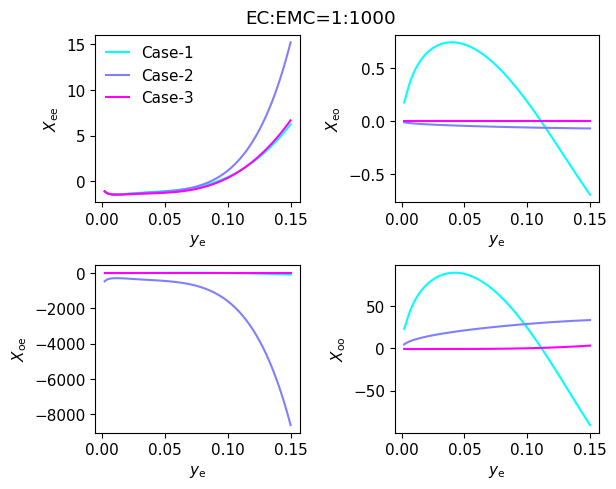

In [18]:
# Compare 3 cases 
def Plot_X_ij(r_EC,r_EMC,Save_fig):
    y_e_array = np.linspace(2e-3,0.15,100)
    Cases = ["Case-1", "Case-2", "Case-3" ]
    cop2 = mpl.cm.get_cmap("cool", len(Cases))
    
    ratios_fix = r_EC/(r_EC+r_EMC)
    fig, Axs = plt.subplots(2,2, figsize=(16/2.54,13/2.54),tight_layout=True)
    axs = Axs.flatten()
    for i in range(len(Cases)):
        x_plot = y_e_array
        y_plot_ee = [];y_plot_oe = [];y_plot_eo = [];y_plot_oo = [];
        for y_e_i in y_e_array:
            y_o_i = (1-2*y_e_i) * ratios_fix # Ratios[i]
            if i==0:
                X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_1(y_e_i,y_o_i)
                y_plot_ee.append( X_ee_sol  ) 
                y_plot_eo.append( X_eo_sol  ) 
                y_plot_oe.append( X_oe_sol  ) 
                y_plot_oo.append( X_oo_sol  ) 
            elif i==1:
                X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_2(y_e_i,y_o_i)
                y_plot_ee.append( X_ee_sol  ) 
                y_plot_eo.append( X_eo_sol  ) 
                y_plot_oe.append( X_oe_sol  ) 
                y_plot_oo.append( X_oo_sol  ) 
            else:
                X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_3(y_e_i,y_o_i)
                y_plot_ee.append( X_ee_sol  ) 
                y_plot_eo.append( X_eo_sol  ) 
                y_plot_oe.append( X_oe_sol  ) 
                y_plot_oo.append( X_oo_sol  ) 

        axs[0].plot(x_plot, y_plot_ee,"-",color=cop2(i),label=Cases[i])
        axs[1].plot(x_plot, y_plot_oe,"-",color=cop2(i),label=Cases[i])
        axs[2].plot(x_plot, y_plot_eo,"-",color=cop2(i),label=Cases[i])
        axs[3].plot(x_plot, y_plot_oo,"-",color=cop2(i),label=Cases[i])
    axs[0].set_ylabel("$X_\mathrm{ee}$")
    axs[1].set_ylabel("$X_\mathrm{eo}$")
    axs[2].set_ylabel("$X_\mathrm{oe}$")
    axs[3].set_ylabel("$X_\mathrm{oo}$")
    fig.suptitle(f"EC:EMC={r_EC}:{r_EMC}",x=0.52, y=0.95)
    for i in range(4):
        axs[i].set_xlabel("$y_\mathrm{e}$")
    axs[0].legend(prop={'family':'DejaVu Sans','size':fs},
        frameon=False,markerscale=1,borderpad=0.2,
        handlelength=1.5,columnspacing=1)
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"X_ij_EC:EMC={r_EC}:{r_EMC}.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"X_ij_EC:EMC={r_EC}:{r_EMC}.svg") 
    return 
Plot_X_ij(r_EC=1,r_EMC=1000,Save_fig=True)

/tmp/ipykernel_5243/3135231293.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("cool", len(Cases))


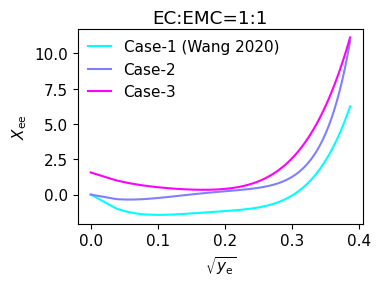

In [19]:
# Now just look at X_ee, see how it behave when y_e approches 0 - it should be correct
def Plot_X_ee(r_EC,r_EMC,Save_fig):
    y_e_array = np.linspace(1e-10,0.15,100)
    Cases = ["Case-1 (Wang 2020)", "Case-2", "Case-3" ]
    cop2 = mpl.cm.get_cmap("cool", len(Cases))
    ratios_fix = r_EC/(r_EC+r_EMC)
    fig, ax = plt.subplots( figsize=(10/2.54,8/2.54),tight_layout=True)
    for i in range(len(Cases)):
        x_plot = y_e_array
        y_plot_ee = []
        for y_e_i in y_e_array:
            y_o_i = (1-2*y_e_i) * ratios_fix # fix y_o as it doesn't matter
            if i==0:
                X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_1(y_e_i,y_o_i)
                y_plot_ee.append( X_ee_sol  ) 
            elif i==1:
                X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_2(y_e_i,y_o_i)
                y_plot_ee.append( X_ee_sol  ) 
                #pass
            else:
                X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_3(y_e_i,y_o_i)
                y_plot_ee.append( X_ee_sol  ) 
        ax.plot(np.sqrt(y_e_array), y_plot_ee,"-",color=cop2(i),label=Cases[i])
    ax.set_ylabel("$X_\mathrm{ee}$")
    ax.set_xlabel(r'$\sqrt{y_{\mathrm{e}}}$') 
    ax.legend(prop={'family':'DejaVu Sans','size':fs},
        frameon=False,markerscale=1,borderpad=0.2,
        handlelength=1.5,columnspacing=1)
    fig.suptitle(f"EC:EMC={r_EC}:{r_EMC}",x=0.55, y=0.90)
    if Save_fig:
        plt.savefig(Path_Fig_save + "/" +  f"X_ij_EC:EMC={r_EC}:{r_EMC}.png", dpi=600)
        plt.savefig(Path_Fig_save + "/" +  f"X_ij_EC:EMC={r_EC}:{r_EMC}.svg") 
    return
Plot_X_ee(r_EC=1,r_EMC=1,Save_fig=True)  # False


/tmp/ipykernel_5243/2799716302.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("cool", len(Cases))


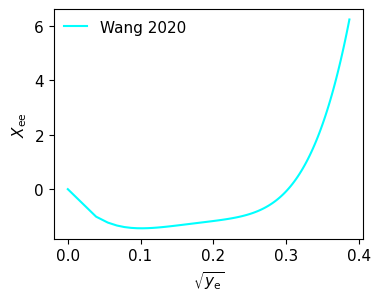

In [23]:
r_EC=1;r_EMC=999;Save_fig=True
y_e_array = np.linspace(1e-10,0.15,100)
Cases = ["Wang 2020", "Case-2", "This work" ]
cop2 = mpl.cm.get_cmap("cool", len(Cases))
ratios_fix = r_EC/(r_EC+r_EMC)
fig, ax = plt.subplots( figsize=(10/2.54,8/2.54),tight_layout=True)
i=0
x_plot = y_e_array
y_plot_ee = []
for y_e_i in y_e_array:
    y_o_i = (1-2*y_e_i) * ratios_fix # fix y_o as it doesn't matter
    if i==0:
        X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_1(y_e_i,y_o_i)
        y_plot_ee.append( X_ee_sol  ) 
    elif i==1:
        #X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_2(y_e_i,y_o_i)
        #y_plot_ee.append( X_ee_sol  ) 
        pass
    else:
        X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_3(y_e_i,y_o_i)
        y_plot_ee.append( X_ee_sol  ) 
ax.plot(np.sqrt(y_e_array), y_plot_ee,"-",color=cop2(i),label=Cases[i])
ax.set_ylabel("$X_\mathrm{ee}$")
ax.set_xlabel(r'$\sqrt{y_{\mathrm{e}}}$') 
ax.legend(prop={'family':'DejaVu Sans','size':fs},
    frameon=False,markerscale=1,borderpad=0.2,
    handlelength=1.5,columnspacing=1)

/tmp/ipykernel_5243/2724281272.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("cool", len(Cases))


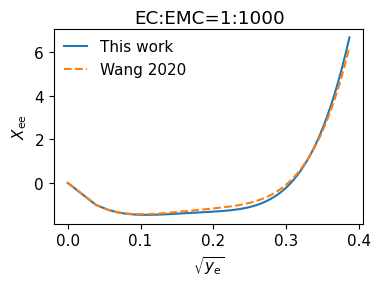

In [26]:
# Compare Wang 2020 and case-3 only - show in paper
def Plot_X_ee(r_EC,r_EMC,Save_fig):
    y_e_array = np.linspace(1e-10,0.15,100)
    Cases = ["Wang 2020", "Case-2", "This work" ]
    cop2 = mpl.cm.get_cmap("cool", len(Cases))
    ratios_fix = r_EC/(r_EC+r_EMC)
    fig, ax = plt.subplots( figsize=(10/2.54,8/2.54),tight_layout=True)
    X_ee_sol_Wang = []; X_ee_sol_Case3 = []; 
    for y_e_i in y_e_array:
        y_o_i = (1-2*y_e_i) * ratios_fix 
        X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_1(y_e_i,y_o_i)
        X_ee_sol_Wang.append( X_ee_sol  ) 

        X_ee_sol,X_eo_sol,X_oe_sol,X_oo_sol = Fun_X_ij_Case_3(y_e_i,y_o_i)
        X_ee_sol_Case3.append( X_ee_sol  ) 
    ax.plot(np.sqrt(y_e_array), X_ee_sol_Case3,"-",label="This work")
    ax.plot(np.sqrt(y_e_array), X_ee_sol_Wang,"--",label="Wang 2020")



    ax.set_ylabel("$X_\mathrm{ee}$")
    ax.set_xlabel(r'$\sqrt{y_{\mathrm{e}}}$') 
    ax.legend(prop={'family':'DejaVu Sans','size':fs},
        frameon=False,markerscale=1,borderpad=0.2,
        handlelength=1.5,columnspacing=1)
    fig.suptitle(f"EC:EMC={r_EC}:{r_EMC}",x=0.55, y=0.90)
    if Save_fig:
        plt.savefig(
            Path_Fig_save + "/Compare_Wang2020_Case_3_" 
            +  f"X_ij_EC:EMC={r_EC}:{r_EMC}.png", dpi=600)
        plt.savefig(
            Path_Fig_save + "/Compare_Wang2020_Case_3_" 
            +  f"X_ij_EC:EMC={r_EC}:{r_EMC}.svg") 
    return
Plot_X_ee(r_EC=1,r_EMC=1000,Save_fig=True)  # False
